In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import pylab as pl
import matplotlib
import pandas as pd
from scipy.io.idl import readsav
from scipy.interpolate import griddata

from PyAstronomy import pyasl
import astropysics.constants as C

import cksgaia.io
import cksgaia.plot
import cksgaia.completeness
import cksgaia.fitting

matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams['figure.figsize'] = (12,10)


Making plots with the j17 table for the full sample and fulton17-weights table for the filtered sample.


# Make some fake planets

0.00902
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  41.  55.
  38.  40.  44.  52.  37.  43.  40.  48.  39.  34.  33.  39.  37.  44.  36.
  45.  54.  44.  41.  41.  59.  42.  55.  51.  43.  49.  41.  45.  36.  53.
  32.  39.  51.  42.  34.  36.  43.  59.  37.  61.  52.  52.  40.  52.  42.
  63.  30.  38.  42.  48.  45.  40.  47.  34.] 1.41333752752


/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


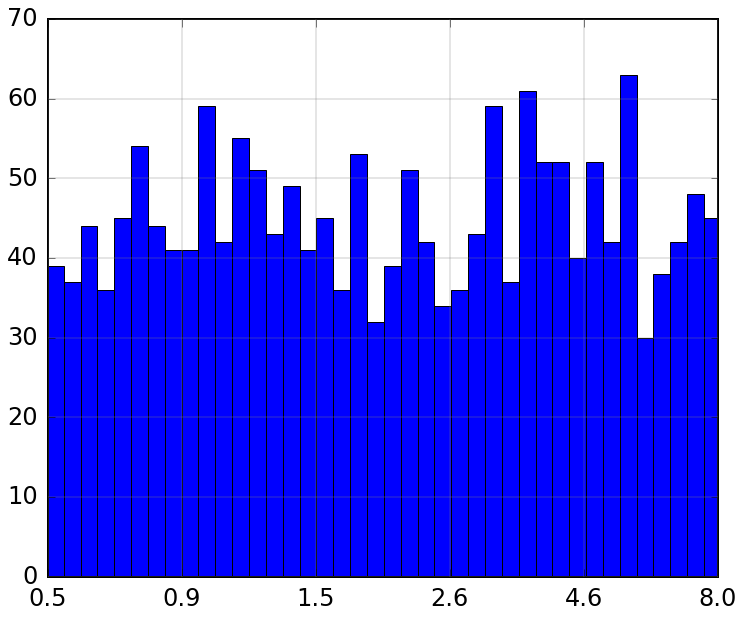

In [2]:
nsim = npl = 4000
r1frac = 0.5
r2frac = 1-r1frac
nstars = 5e4

# broad distributions
# simulated_periods = np.random.lognormal(3.5, 1.0, size=int(np.round(npl*r1frac)))
# simulated_periods = np.append(simulated_periods, np.random.lognormal(2.5, 0.9, size=int(np.round(npl*r2frac))))
# simulated_radii = np.random.lognormal(1.05, 0.32, size=int(np.round(npl*r1frac)))
# simulated_radii = np.append(simulated_radii, np.random.lognormal(0.0, 0.20, size=int(np.round(npl*r2frac))))

# narrow distributions
# simulated_periods = np.random.lognormal(3.5, 0.7, size=int(np.round(npl*r1frac)))
# simulated_periods = np.append(simulated_periods, np.random.lognormal(2.5, 0.9, size=int(np.round(npl*r2frac))))
# simulated_radii = np.random.lognormal(0.867, 0.17, size=int(np.round(npl*r1frac)))
# simulated_radii = np.append(simulated_radii, np.random.lognormal(0.26, 0.12, size=int(np.round(npl*r2frac))))

# uniform distributions
simulated_periods = 10**np.random.uniform(np.log(1), np.log(200), size=int(npl))
simulated_radii = 10**(np.random.uniform(np.log(0.5), np.log(8), size=int(npl)))

random_order = np.array(range(nsim))
np.random.shuffle(random_order)
simulated_periods = simulated_periods[random_order]
simulated_radii = simulated_radii[random_order]

xbins = np.logspace(-2,1,100)
bins, edges, _ = pl.hist(simulated_radii, bins=xbins)
pl.semilogx()
pl.xlim(0.5, 8)

pl.xticks(np.logspace(np.log10(0.5), np.log10(8), 6))

ax = pl.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))


simdf = pd.DataFrame([])
simdf['koi_period'] = simulated_periods
simdf['iso_prad'] = simulated_radii
simdf['koi_period_err1'] = simulated_periods*1e-4
simdf['iso_prad_err1'] = simulated_radii*0.10
#simdf['iso_smass'] = 1.0
#simdf['iso_srad'] = 1.0
#simdf['kic_kepmag'] = 12.5
#simdf['CDPP3'] = 0.0
#simdf['CDPP6'] = 0.0
#simdf['CDPP12'] = 0.0

print len(simulated_radii[(simulated_radii < 4) & (simulated_radii > 2)]) / nstars

print bins, 4.49300000e+03 / 3.17900000e+03

/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


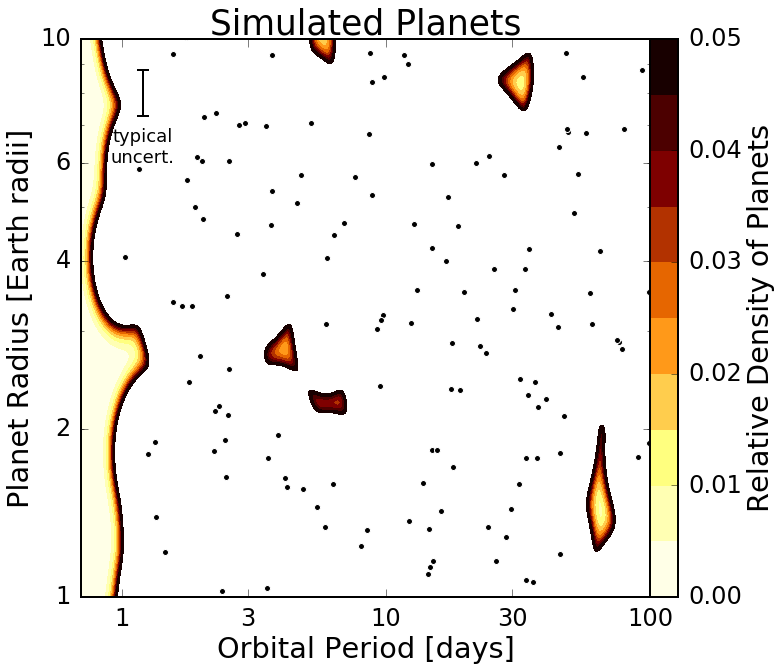

In [3]:
reload(cksgaia.plot)

#ax, xi, yi, zi = cksrad.plotting.contour_plot(simdf.head(1000), 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
#                            pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[2.0,7], nbins=16)
ax, xi, yi, wzi = cksgaia.plot.contour.contour_plot_kde(simdf.head(1000), 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
                            pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[1.2,8], weighted=False, nstars=1)

pl.title("Simulated Planets")
pl.xlabel('Orbital Period [days]')
pl.ylabel('Planet Radius [Earth radii]')

pl.savefig('/home/bfulton/Dropbox/plots/simulated_planets.pdf')

# Put them around the stars in my sample

In [4]:
reload(cksgaia.io)

#kic = readsav('/Users/bfulton/Dropbox/cks_share2/comparison_catalogs/kic_q0_q17.dat')
#kic = pd.read_msgpack('/Users/bfulton/Dropbox/cks_share2/comparison_catalogs/kic_q0_q17.msg')
kicselect = cksgaia.io.load_table('kic')

physmerge = cksgaia.io.load_table('fulton17')

kois = pd.merge(physmerge, kicselect, left_on='id_kic', right_on='KICID')

random_kic = kicselect.iloc[np.random.choice(kicselect.index, size=nsim, replace=True)]

simdf['id_kic'] = random_kic['id_kic'].values
simdf['iso_srad'] = random_kic['kic_srad'].values
simdf['iso_smass'] = random_kic['kic_smass'].values
#simdf['kic_kepmag'] = random_kic['kic_kepmag'].values

kois = simdf

kois['koi_sma'] = (kois['iso_smass']*(kois['koi_period']/365.)**2)**(1/3.)
a = (C.G*kois['iso_srad']*C.Ms*((kois['koi_period']*(24*3600.))/(2*np.pi))**2)**(1/3.) * C.aupercm
R = kois['iso_srad']*C.Rs * C.aupercm
kois['koi_duration'] = (kois['koi_period']*24./np.pi)*np.arcsin(R/a)
kois['koi_ror'] = (kois['iso_prad'] * (C.Re/C.Rs))/kois['iso_srad']
kois['koi_dor'] = (kois['koi_sma'] / 0.00465047) / kois['iso_srad']

kicselect = cksgaia.completeness.fit_cdpp(kicselect)
print kicselect['id_kic'].count()

read table kic from load_table_cache.hdf
read table fulton17 from load_table_cache.hdf


/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


199991


/home/bfulton/code/cksgaia/cksgaia/completeness.py:36: RankWarning: Polyfit may be poorly conditioned
  pfit = np.polyfit(1 / np.sqrt([3., 6., 12.]), cdpp_arr, 2)


In [5]:
kois = pd.merge(kois, kicselect, on='id_kic', suffixes=['','_ks'])

x = 1/np.sqrt(kois['koi_duration'])
kois['koi_cdpp_dur'] = kois['kic_cdpp_fit0'] + kois['kic_cdpp_fit1'] * x + kois['kic_cdpp_fit2'] * x**2    
kois['koi_snr'] = kois['koi_ror']**2 * (kois['koi_period']/kois['kic_tobs'])**-0.5 * 1/(kois['koi_cdpp_dur']*1e-6)

kois.head(5)

,koi_period,iso_prad,koi_period_err1,iso_prad_err1,id_kic,iso_srad,iso_smass,koi_sma,koi_duration,koi_ror,...,kic_nquarters,kic_tobs,kic_cdpp3,kic_cdpp6,kic_cdpp12,kic_cdpp_fit0,kic_cdpp_fit1,kic_cdpp_fit2,koi_cdpp_dur,koi_snr
0,106857.308907,24.793143,10.685731,2.479314,11670498,1.090,1.174,46.511850,91.272761,0.208211,...,17,1530,176.061005,128.154007,95.182999,54.953930,167.792982,461.035932,77.568300,66.875373
1,141.155792,97.698336,0.014116,9.769834,10969855,1.559,1.398,0.593526,12.713423,0.573640,...,17,1530,118.654999,117.096001,106.135002,61.277072,153.314653,310.711722,128.715144,8416.771673
2,1.472757,108.732428,0.000147,10.873243,7704028,2.071,1.211,0.027015,3.408928,0.480593,...,17,1530,102.653999,78.550003,58.990002,34.057893,102.846096,268.811270,168.616004,44150.543203
3,3.705317,9.335491,0.000371,0.933549,7440759,12.059,1.384,0.052248,15.547679,0.007086,...,7,630,224.658997,213.141998,202.210999,116.746574,279.068383,588.295347,225.359391,2.905564
4,164.146508,3.154793,0.016415,0.315479,5388018,0.864,0.866,0.559498,9.020118,0.033424,...,17,1530,81.489998,77.656998,80.209999,46.309265,101.676877,213.390905,103.820957,32.851557


# Calculate weights for each simulation

In [6]:
reload(cksgaia.completeness)
#import cProfile
kois = cksgaia.completeness.get_weights(kois, kicselect)

/home/bfulton/code/cksgaia/cksgaia/completeness.py:91: RuntimeWarning: divide by zero encountered in divide
  1 / (kois['koi_cdpp_dur'].values * 1e-6)
/home/bfulton/code/cksgaia/cksgaia/completeness.py:61: RuntimeWarning: divide by zero encountered in divide
  other_snr = rors ** 2 * (per / kicselect['kic_tobs'].values) ** -0.5 * (1 / (cdpp_durs * 1e-6))
/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/bfulton/code/cksgaia/cksgaia/completeness.py:53: RuntimeWarnin

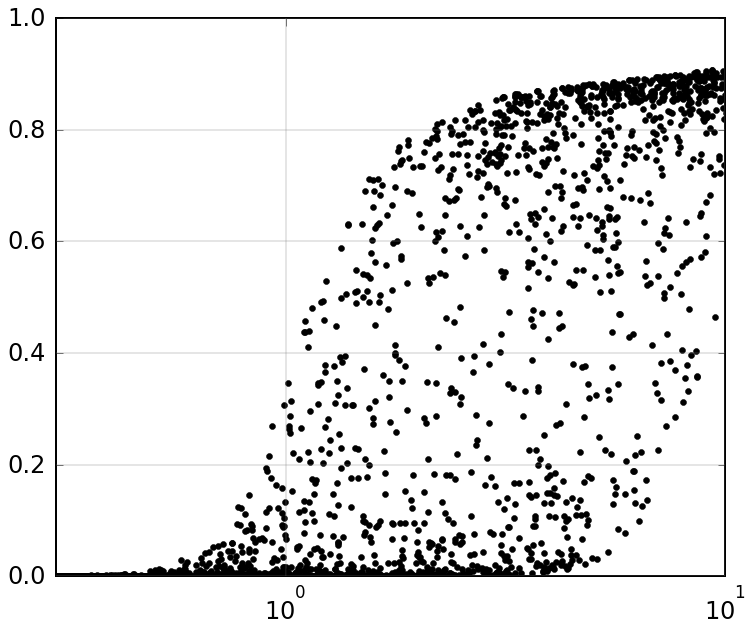

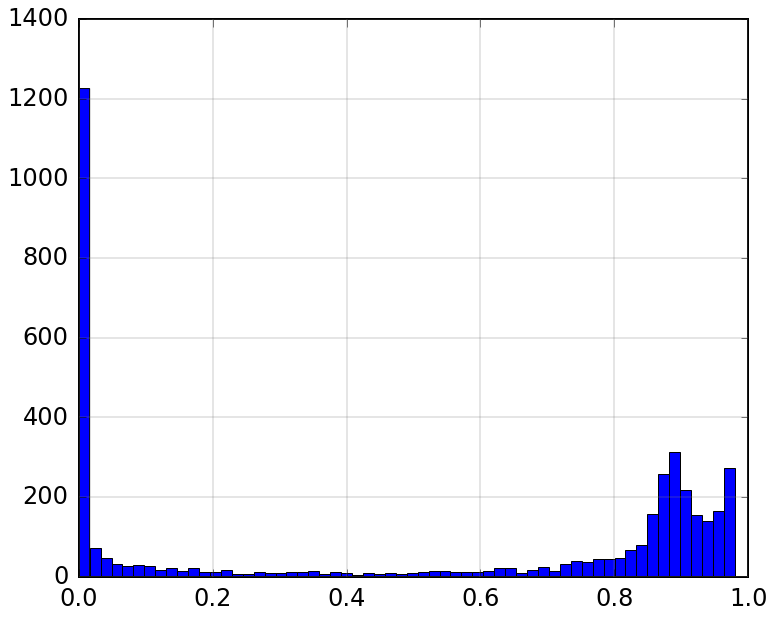

In [7]:
pl.plot(kois['iso_prad'], kois['det_prob'], 'ko')
pl.semilogx()
#pl.loglog()
pl.xlim(0.3,10)

pl.show()
kois['det_prob'].hist(bins=60)

# Select planet detections based on weights

In [8]:
obsdf = kois.copy()

print len(obsdf)
detected = np.ones(len(obsdf), dtype=bool)
r = np.random.uniform(0,1, size=len(obsdf))
detected = r <= 1/obsdf['weight']
obsdf = obsdf[detected]
print len(obsdf)

4000
103


In [83]:
obsdf.query('iso_prad > 2 & iso_prad < 4')['weight'].sum() / nstars

0.32484503798881703

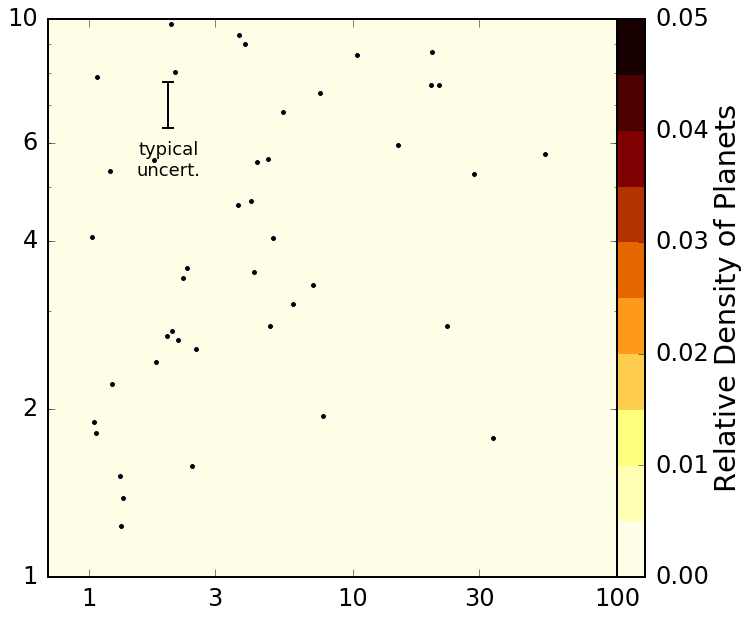

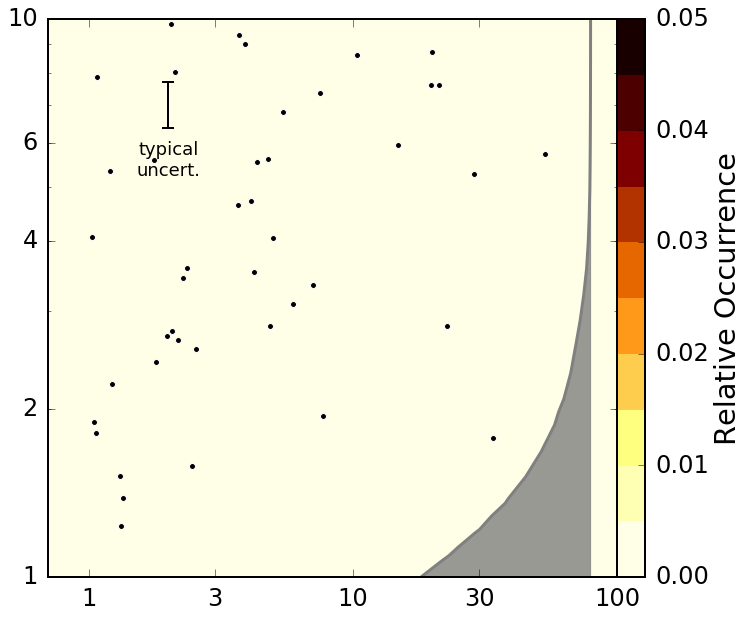

In [11]:
ax, xi, yi, zi = cksgaia.plot.contour.contour_plot_kde(obsdf, 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
                            pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[2.0,7], weighted=False)

pl.show()
# ax, xi, yi, wzi = cksrad.plotting.contour_plot(obsdf, 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
#                             pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[2.0,7], nbins=18, weighted=True)
# pl.show()
ax, xi, yi, wzi = cksgaia.plot.contour.contour_plot_kde(obsdf, 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
                            pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[2.0,7], weighted=True, nstars=5e4)

xc, yc = np.genfromtxt('/home/bfulton/code/cksrad/data/detectability_p1.txt', unpack=True)
pl.fill_between(xc, yc, 1e-6, color='0.5', alpha=0.8)
pl.plot(xc, yc, color='0.5', lw=3)

In [12]:
Redges = np.logspace(np.log10(0.5), np.log10(20), 40)
Pedges = np.logspace(np.log10(1.0), np.log10(100), 40)

Rcen = 10**(np.log10(Redges[:-1]) + np.diff(np.log10(Redges)).mean()/2)
Pcen = 10**(np.log10(Pedges[:-1]) + np.diff(np.log10(Pedges)).mean()/2)

detections,_,_ = np.histogram2d(obsdf['koi_period'], obsdf['iso_prad'], bins=[Pedges,Redges])
wdetections,_,_ = np.histogram2d(obsdf['koi_period'], obsdf['iso_prad'], bins=[Pedges,Redges], weights=obsdf['weight'])

/scr/bfulton/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


0.0155030516279


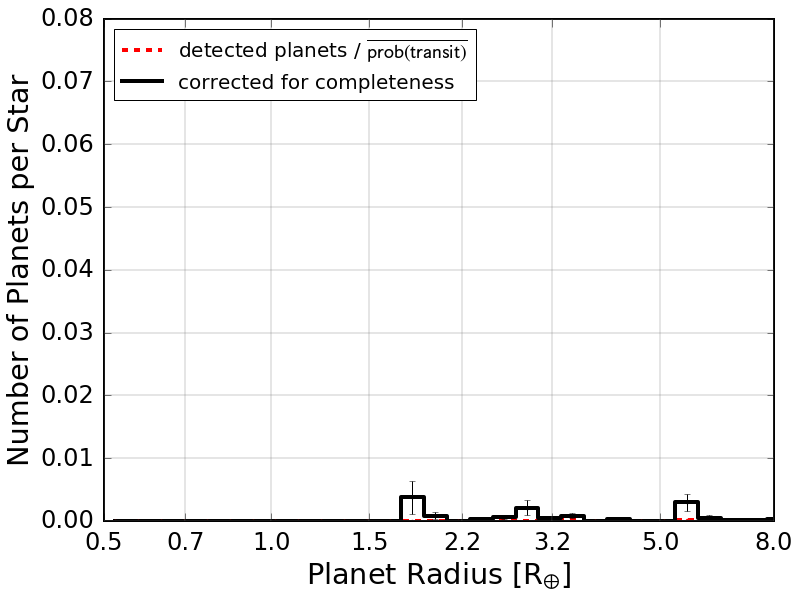

In [13]:
fig = pl.figure(figsize=(12,9))

sfac = 1/obsdf['tr_prob'].mean()
rhist = np.sum(detections, axis=0) 
rhistn = rhist / nstars * sfac
rerr = np.sqrt(rhist) / nstars * sfac

whist = np.sum(wdetections, axis=0) 
whistn = whist / nstars
werr = rerr * (whistn/rhistn)

whistn,_ = np.histogram(obsdf['iso_prad'], weights=obsdf['weight'], bins=Redges)
whistn /= nstars

pl.step(Rcen, rhistn, lw=4, color='r', where='mid', linestyle='--', label='detected planets / $\\overline{\\rmprob(transit)}$')
pl.step(Rcen, whistn, lw=4, color='k', where='mid', linestyle='-', label='corrected for completeness')
pl.errorbar(Rcen, rhistn, yerr=rerr, fmt='r.')
pl.errorbar(Rcen, whistn, yerr=werr, fmt='k.')

# pl.axvline(1.1)
# pl.axvline(1.7)
# pl.axvline(2.0)
# pl.axvline(3.0)
# print np.log10(3.) - np.log10(2)
# print np.log10(1.7) - np.log10(1.1)

pl.xlim(0.5,6)
pl.ylim(0,0.08)
pl.semilogx()
ax = pl.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

pl.xticks(np.array([0.5,0.7,1.0,1.5,2.2,3.2,5,8.0]))

pl.ylabel('Number of Planets per Star')
pl.xlabel('Planet Radius [R$_{\oplus}$]')

pl.legend(loc='upper left')

print np.sum(whistn)

In [14]:
reload(cksrad.fitting)
kx, ky = cksrad.fitting.wkde(obsdf['iso_prad'].values, obsdf['iso_prad_err1'].values, obsdf['weight'].values)
okx, oky = cksrad.fitting.wkde(obsdf['iso_prad'].values, obsdf['iso_prad_err1'].values, 1+0*obsdf['weight'].values)
ky /= nstars
oky = oky / nstars * sfac

pl.plot(kx, ky, lw=3, color='k')
pl.plot(okx, oky, 'r--', lw=3)

pl.semilogx()
pl.xlim(0.5, 8)

pl.xticks(np.logspace(np.log10(0.5), np.log10(8), 6))

ax = pl.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))


print np.trapz(ky[(kx>1.1) & (kx<1.7)])


NameError: name 'cksrad' is not defined

In [17]:
row = kicmerge.query('id_kic == 10584140')

dur = row['koi_duration']
cdpp3 = row['CDPP3'].values[0][row['CDPP3'].values[0] > 0]
cdpp6 = row['CDPP6'].values[0][row['CDPP6'].values[0] > 0]
cdpp12 = row['CDPP12'].values[0][row['CDPP12'].values[0] > 0]
cdpp_arr = [np.median(cdpp3), np.median(cdpp6), np.median(cdpp12)]
#cdpp3.append(np.median(row['CDPP3']))
#cdpp6.append(np.median(row['CDPP6']))
#cdpp12.append(np.median(row['CDPP12']))

# Extraoplate CDPP to transit duration
fit = np.polyfit(1/np.sqrt([3.,6.,12.]), cdpp_arr, 2)
cdpp_dur = np.polyval(fit, 1/np.sqrt(dur))

print cdpp_dur

[ 43.2530024]


In [18]:
r = row['iso_prad'].values[0]
med_srad = row['iso_srad'].values[0]
p = row['koi_period'].values[0]
print r, med_srad, p

snr = (r*(C.Re/C.Rs) / med_srad)**2 * (p/t_obs)**-0.5 * (1/(cdpp_dur*1e-6))
print snr

2.49215429293 1.39 44.7974241918
[ 35.55090253]


In [ ]:
kicmerge['koi_num'] = kicmerge['id_koicand'].str.replace('K0','')
kicmerge.to_csv('/Users/bfulton/Dropbox/code/tess_sens/radkois.txt', sep=' ', 
                columns=['koi_num', 'iso_smass', 'iso_srad'], index=False, header=False)
kicmerge.to_csv('/Users/bfulton/Dropbox/code/tess_sens/radkiclist', sep=' ', columns=['id_kic'], index=False)

In [360]:
reload(cksrad.fitting)
reload(cksrad.plotting)

#x, y, z = cksrad.fitting.wkde2D(obsdf['koi_period'].values, obsdf['iso_prad'].values, 
#                                obsdf['koi_period_err1'].values, obsdf['iso_prad_err1'].values,
#                                obsdf['weight'].values)
ax, x, y, z = cksrad.plotting.contour_plot_kde(obsdf, 'koi_period', 'iso_prad', xlim=[0.4,300.0], ylim=[0.5, 20], ylog=True,
                            pltxlim=[0.7, 100.0], pltylim=[1.0,10], epos=[2.0,7])
z /= 5e4

TypeError: wkde2D() takes exactly 5 arguments (4 given)

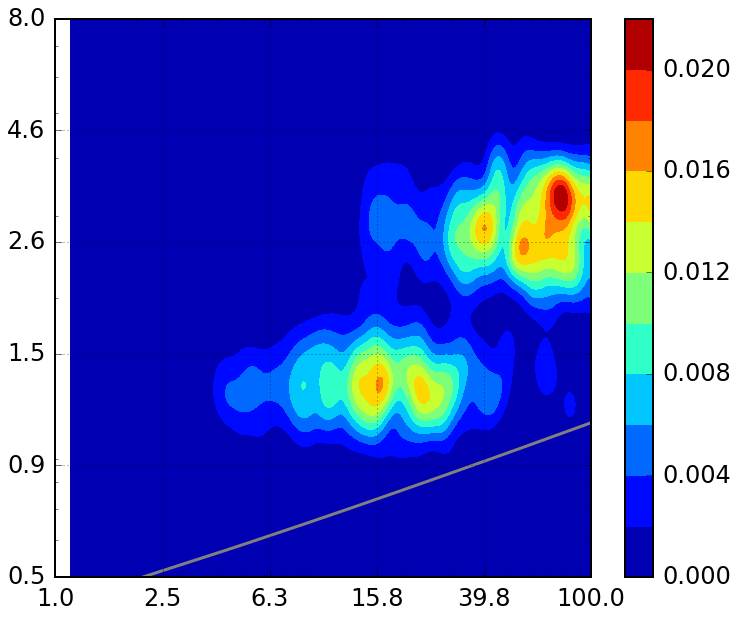

In [357]:
pl.contourf(10**x, 10**y, z, 10)
pl.colorbar()
pl.loglog()

xc, yc = np.genfromtxt('/Users/bfulton/code/cksrad/data/pipeline_compelteness_p25.txt', unpack=True)
pl.plot(xc, yc, color='0.5', lw=3)


pl.ylim(0.5, 8)
pl.xlim(1,100)

pl.yticks(np.logspace(np.log10(0.5), np.log10(8), 6))
pl.xticks(np.logspace(0,2,6))

ax = pl.gca()
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))



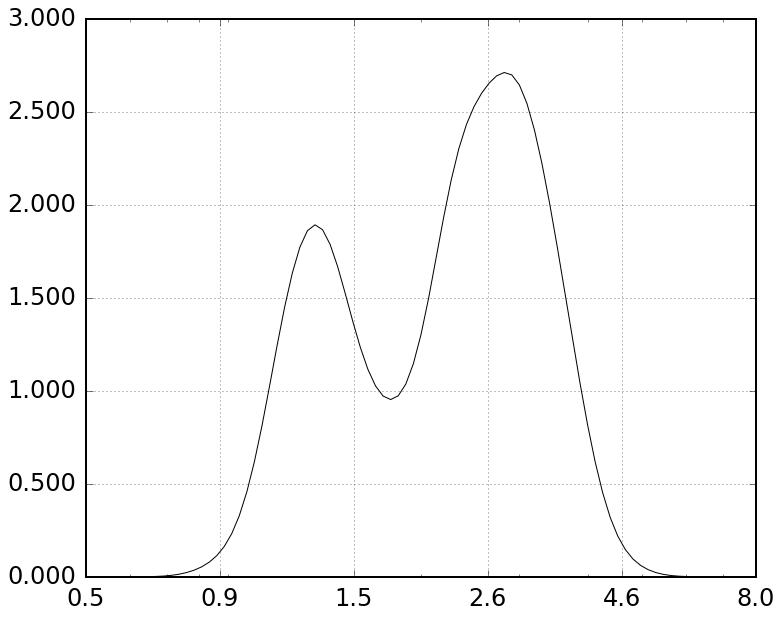

In [358]:
#print np.nansum(z, axis=0).shape
ky = np.nansum(z, axis=0)
kx = np.nansum(z, axis=1)

pl.plot(10**y[0,:], ky, 'k-')

pl.semilogx()

pl.xlim(0.5,8)
pl.xticks(np.logspace(np.log10(0.5), np.log10(8), 6))

ax = pl.gca()
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.3f'))
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))



# Delta Functions

In [50]:
nsim = 10000
r1_dist = np.zeros((nsim,)) + np.random.normal(np.log10(1.29), 0.0967*1.29, size=nsim)
r2_dist = np.zeros_like(r1_dist) + np.random.normal(np.log10(2.39), 0.0967*2.39, size=nsim)
dist = np.append(10**r1_dist, 10**r2_dist)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] [  5.00000000e-05   5.49602204e-05   6.04125165e-05   6.64057045e-05
   7.29934431e-05   8.02347144e-05   8.81943517e-05   9.69436202e-05
   1.06560855e-04   1.17132161e-04   1.28752188e-04   1.41524972e-04
   1.55564873e-04   1.70997595e-04   1.87961310e-04   2.06607900e-04
   2.27104315e-04   2.49634064e-04   2.74398863e-04   3.01620440e-04
   3.31542517e-04   3.64432996e-04   4.00586356e-04   4.40326288e-04
   4.84008597e-04   5.32024384e-04   5.84803548e-04   6.42818637e-04
   7.06589080e-04   7.76685831e-04   8.53736489e-04   9.38430912e-04
   1.03152740e-03   1.13385946e-03   1.24634332e-03   1.36998607e-03
   1.50589472e-03   1.65528612e-03   1.81949780e-03   2.00000000e-03]


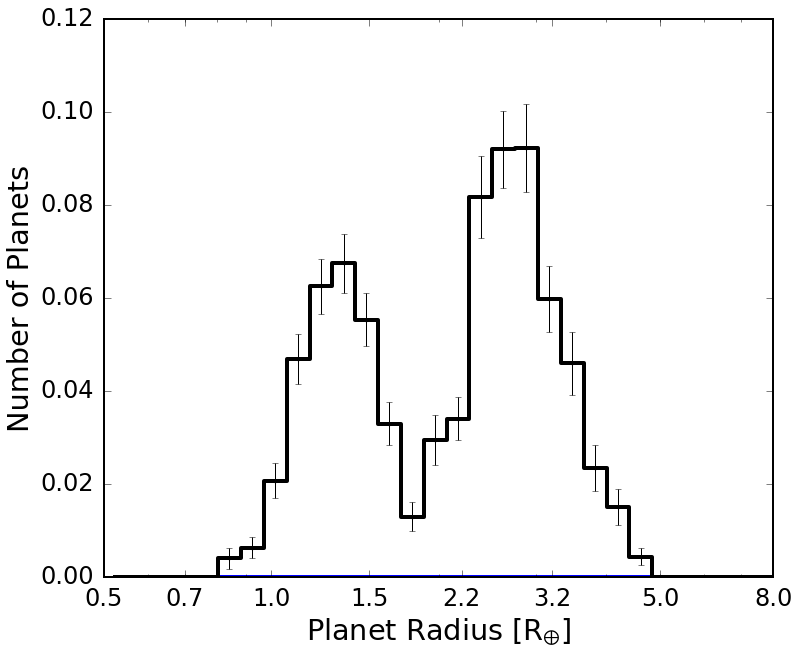

In [52]:
shist,_ = np.histogram(dist, bins=Redges)
#pl.hist(dist, bins=Redges, histtype='step', lw=4, color='b', normed=True)
print shist, Redges

pl.step(Rcen, shist, lw=4, color='b', where='mid', linestyle='-', label='simulated')
pl.step(Rcen, whistn, lw=4, color='k', where='mid', linestyle='-', label='observed')
pl.errorbar(Rcen, whistn, yerr=werr, fmt='k.')

pl.grid(False)
pl.xlim(0.7,6)
pl.semilogx()

ax = pl.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

pl.xticks(np.array([0.5,0.7,1.0,1.5,2.2,3.2,5,8.0]))


pl.ylabel('Number of Planets')
pl.xlabel('Planet Radius [R$_{\oplus}$]')

